In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.colors import PowerNorm
from matplotlib.patches import Rectangle
import struct
import imageio
import collections
import pickle
import re
import requests
import pandas as pd
from pathlib import Path
import pretty_errors
from IPython import display
from IPython.core.interactiveshell import InteractiveShell
from filter_BU import filt_B
import my_pyrotd
from post_processing.la_habra import *

InteractiveShell.ast_node_interactivity = "last_expr"
# InteractiveShell.ast_node_interactivity = "all"
np.errstate(divide='ignore')
#%config InlineBackend.figure_format = 'retina'
%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.tight_layout(rect=(0, 0.03, 1, 0.95))
# rcparams = {'font.size': 16,
#             'xtick.labelsize': 10,
#             'ytick.labelsize': 10,
#             'legend.fontsize': 14,
#             'axes.titlesize': 16,
#             'axes.labelsize': 14,
#             'lines.linewidth': 1.5,
#             'figure.dpi': 300}
# mpl.rcParams.update(rcparams)
mpl.style.use('seaborn')
import seaborn as sns; 
sns.set(context='paper', style='whitegrid', font_scale=1, rc={"xtick.bottom" : True, "ytick.left" : True})
sns.set_style({'legend_frameon':False})

<Figure size 432x288 with 0 Axes>

In [8]:
# band pass filter
lowf, highf = 0.1, 5
osc_freqs = np.concatenate((np.linspace(0.1, 10, 100),
                        [1/3, 2, 3, 4, 5]))
osc_freqs = sorted(osc_freqs)
fqs = [2, 3, 4, 5]


nx, ny = 3500, 3500
mx, my = 3456, 3456
px, py = (nx - mx) // 2, (ny - my) // 2
tmax, dt, dh = 30, 0.001, 0.008
tskip, wstep = 20, 300
nd = 250  # avoid abc boudnary, which is at most 80 * 3 = 240
dt = dt * tskip
nt = int(tmax / dt)
fs = 1 / dt
nfile = nt // wstep


# Source index
src_loc = np.genfromtxt('input/source.txt', skip_header=10, usecols=[1, 2])
srcidx = [(sum(x) / len(src_loc) - 1) / 1000 // dh + 1 for x in zip(*src_loc)]


# sites of recordings
r = requests.get('http://hypocenter.usc.edu/research/High-F/lahabra_obs_2019_05_31/')
rec_sites = re.findall('(?<=V2">).+(?=\.V2<)', r.text)

temp = np.genfromtxt('la_habra_small_statlist_3456.idx', delimiter=" ", dtype="S8, i4, i4")
syn_sites = [(name.decode('UTF-8').replace('_', ''), ix, iy) for name, ix, iy in temp \
             if nd < ix < mx - nd and nd < iy < my - nd]  

cross_sites = []
for i in range(len(syn_sites)):
    if syn_sites[i][0] in rec_sites:
        cross_sites += syn_sites[i],
syn_sites = cross_sites

grids = np.fromfile('surf.grid', dtype='float64').reshape(my, mx, 3)[:, :, :2]
lat = grids[:, mx // 2, 1]
lon = grids[my // 2, :, 0]
grids = np.reshape(grids, (-1, 2))

# from scipy import spatial
# kdtree = spatial.cKDTree(grids)

vs30 = np.fromfile('mesh', dtype='float32', count=mx * my * 3, offset = mx * my * 3 * 3).reshape(my, mx, 3)[:, :, 1]

In [ ]:
f = open(glob.glob('./*.srf')[0],'r')
f.readline()
f.readline()
token = f.readline()
f.readline()
print(f.readline())
nx = int(token.split()[2])
nz = int(token.split()[3])
npt = nx * nz

idx = np.zeros((nz * nx, 2), dtype='float32')

for j in range(nz):
    sys.stdout.write("\rreading subfault %d of %d" % (j+1, nz))
    sys.stdout.flush()
    for i in range(nx):
        nl1 = f.readline().split()
        nl2 = f.readline().split()
        ll[j * nx + i] = [float(nl1[0]), float(nl1[1])]
        stk = float(nl1[3]) - theta_rot
        dip = float(nl1[4])
        area = float(nl1[5]) / 1.e4 / 4  # reduce the dx from 200 to 100
        tinit= float(nl1[6])
        dt = float(nl1[7])
        rake = float(nl2[0])
        slip = float(nl2[1]) / 1.e2
        nt1 = int(nl2[2]) 
        nskip1 = int(np.ceil(nt1 / 6.))
        for l in range(nskip1):
            tmp = f.readline()
        trise = nt1 * dt
        res[j, i, :] = [stf_type, slip, tinit, trise, area, 0.0, stk, dip, rake, 0.0, 0.0, 0.0]


In [31]:
#!/usr/bin/env python
"""
Created on Wed Oct 17 2018

@author: Zhifeng Hu <zhh076@ucsd.edu>
Input:  *.srf, srf source file from CyberShake
        awp.USC.media, mesh file, including vp, vs, rho
        fault_idx.bin indices of subfaults in the mesh

Output: subfaults.idx, fault information
        sliprate.bin, sliprate time history on each subfault
"""

import numpy as np
from numpy import sin, cos, pi, sqrt
from scipy.signal import resample
from scipy.interpolate import interp1d
from struct import pack
import os
import sys
import glob
import time

def upsample(s1, dt1, dt2, nt2):
    '''
    For upsample only, since no anti-aliasing is implemented.
    '''
    s2 = np.zeros((nt2,))
    for n in range(nt2):
        t_n = dt2 * n
        n_l = np.floor(t_n / dt1)
        n_r = np.ceil(t_n / dt1)
        if n_l==n_r:
            s2[n] = s1[n_l] 
        elif n_r > len(s1) - 1:
            s2[n] = s1[n_l]
        else:
            t_l = n_l * dt1
            t_r = n_r * dt1
            s2[n] = s1[n_l] + (s1[n_r] - s1[n_l]) * (t_n - t_l) / (t_r - t_l)
    return s2

nt_ref = 5000

dz = 0.008
theta_rot = 39.9

f = open(glob.glob('./*.srf')[0],'r')
f.readline()
f.readline()
token = f.readline()
nx = int(token.split()[2])
nz = int(token.split()[3])
npt = nx * nz
mz = int(float(token.split()[5]) / dz) + 1
final_sr = np.zeros((nx, nz, nt_ref), dtype='float32') # (nx, nz, nt) --> (nt, nz, nx) to save

dtop = np.floor(float(f.readline().split()[2]) / dz) * dz 
print(f.readline())

f_sliprate = open("sliprate.bin", 'wb')
f_fault = open("subfaults.idx", 'w')


mu = np.zeros((mz, my, mx), dtype='float64')
with open('../cvm/la_habra_small_cvmsi_8m_3456.media', 'rb') as f_media:
    f_media.seek(int(dtop // dz) * 4 * my * mx * 3, 0)
    for i in range(mz):
        data = np.frombuffer(f_media.read(4 * my * mx * 3), 
                             dtype='float32').reshape(my, mx, 3)
        mu[i, :, :] = data[:, :, 2] * data[:, :, 1] ** 2

print(mu.shape)

for j in range(nz):
    sys.stdout.write("\rreading subfault %d of %d" % (j+1, nz))
    sys.stdout.flush()
    for i in range(nx):
        sr = np.zeros((nt_ref,))
        nl1 = f.readline().split()
        nl2 = f.readline().split()
        iy, ix = np.unravel_index(kdtree.query([float(nl1[0]), float(nl1[1])])[1], (my, mx))
        iz = int(float(nl1[2]) / dz)
        k = max(0, int((float(nl1[2]) - dtop) / dz) - 1)
        stk = float(nl1[3]) - theta_rot
        dip = float(nl1[4])
        rake = float(nl2[0])
        area = float(nl1[5]) / 1.e4  # cm^2 --> m^2
        tinit= float(nl1[6])
        dt = float(nl1[7])
        nt1 = int(nl2[2])
        nskip1 = int(np.ceil(nt1 / 6.))
        sliprate1 = np.zeros((nt1), dtype=float)
        p1 = 0
        for l in range(nskip1):
            tmp = f.readline()
            nt = len(tmp.split())
            for n in range(nt):
                sliprate1[p1] = float(tmp.split()[n]) / 1.e2  # cm/s2 --> m/s2
                p1 += 1
        t1 = int(np.floor(tinit/dt))
        try:
            sr[t1 : t1+len(sliprate1)] = sliprate1.copy()
        except:
            print(nt1, len(sliprate1), t1)
            print(nl2)
            sys.exit(-1)
        f_fault.write("{0} {1} {2} {3} {4} {5} {6} {7}\n".format(
                    ix, iy, iz, area, mu[k, j, i], stk, dip, rake))
        final_sr[i, j, :] = sr
    print(k)
        
# reverse the fault horizontally when it starts from the right portion.
# if x1 > x2:
#     final_sr = final_sr[::-1, :, :]
final_sr = np.float32(final_sr.T)
final_sr.tofile(f_sliprate, format='float32')
f_fault.close()
f_sliprate.close()

# if x1 > x2:
#     print ("Reversed!")
#     f_in = open('subfaults.idx', 'r')
#     data = f_in.readlines()
#     f_in.close()
#     time.sleep(10)
#     f_out = open('subfaults.idx', 'w')
#     for j in range(2 * nz):
#         f_out.writelines(reversed(data[2 * nx * j : 2 * nx * (j + 1)]))
#     f_out.close()


POINTS 15625

(313, 3456, 3456)
reading subfault 1 of 1250
reading subfault 2 of 1253
reading subfault 3 of 1255
reading subfault 4 of 1257
reading subfault 5 of 12510
reading subfault 6 of 12512
reading subfault 7 of 12514
reading subfault 8 of 12517
reading subfault 9 of 12519
reading subfault 10 of 12521
reading subfault 11 of 12524
reading subfault 12 of 12526
reading subfault 13 of 12528
reading subfault 14 of 12531
reading subfault 15 of 12533
reading subfault 16 of 12535
reading subfault 17 of 12538
reading subfault 18 of 12540
reading subfault 19 of 12542
reading subfault 20 of 12545
reading subfault 21 of 12547
reading subfault 22 of 12550
reading subfault 23 of 12552
reading subfault 24 of 12554
reading subfault 25 of 12557
reading subfault 26 of 12559
reading subfault 27 of 12561
reading subfault 28 of 12564
reading subfault 29 of 12566
reading subfault 30 of 12568
reading subfault 31 of 12571
reading subfault 32 of 12573
reading subfault 33 of 12575
reading subfault 34 of 1

In [29]:
mu = np.zeros((mz, my, mx), dtype='float64')
with open('../cvm/la_habra_small_cvmsi_8m_3456.media', 'rb') as f_media:
    f_media.seek(int(dtop // dz) * 4 * my * mx * 3, 0)
    for i in range(mz):
        data = np.frombuffer(f_media.read(4 * my * mx * 3), 
                             dtype='float32').reshape(my, mx, 3)
        mu[i, :, :] = data[:, :, 2] * data[:, :, 1] ** 2

print(int(dtop // dz) * 4 * my * mx * 3)
print(mu.shape)
print(mu[291, 100, 100])

NameError: name 'mz' is not defined

In [3]:
def read_topo(fname):
    pad = 8
    with open(fname, 'rb') as fout:
        mx, my, pad = np.frombuffer(fout.read(12), dtype='int32')
        topo = np.frombuffer(fout.read((mx + 2 * pad) * (my + 2 * pad) * 4), dtype='float32').reshape(mx + 2 * pad, my + 2 * pad).T
        return topo[pad : -pad, pad : -pad]



213.0 213.0 323.0 269.92
0, CE13066, ix = 2351, iy = 1714 232.905
1, CE13873, ix = 2078, iy = 3157 244.02821
2, CE13878, ix = 2545, iy = 2752 266.93182
3, CE13879, ix = 2104, iy = 1978 237.7725
4, CE13880, ix = 1976, iy = 2644 261.43573
5, CE13881, ix = 1560, iy = 2696 256.8157
6, CE13883, ix = 3121, iy = 2580 269.92
7, CE13885, ix = 3089, iy = 832 323.0
8, CE13886, ix = 2683, iy = 1108 269.92
9, CE13894, ix = 3121, iy = 1432 315.29498
10, CE14026, ix = 1115, iy = 1579 269.92
11, CE14027, ix = 674, iy = 1917 213.0
12, CE14028, ix = 304, iy = 2223 235.76999
13, CE14400, ix = 1348, iy = 838 248.48322
14, CE14829, ix = 533, iy = 995 160.48
15, CE14830, ix = 956, iy = 679 339.08002
16, CE14840, ix = 1026, iy = 2527 237.29501
17, CE14869, ix = 1193, iy = 371 260.9407
18, CE14937, ix = 1297, iy = 2014 256.8157
19, CIBRE, ix = 2417, iy = 1191 255.9082
20, CIDLA, ix = 1033, iy = 781 339.08002
21, CIFUL, ix = 2380, iy = 2306 261.9032
22, CILBW1, ix = 1544, iy = 300 253.18571
23, CIOLI, ix = 172

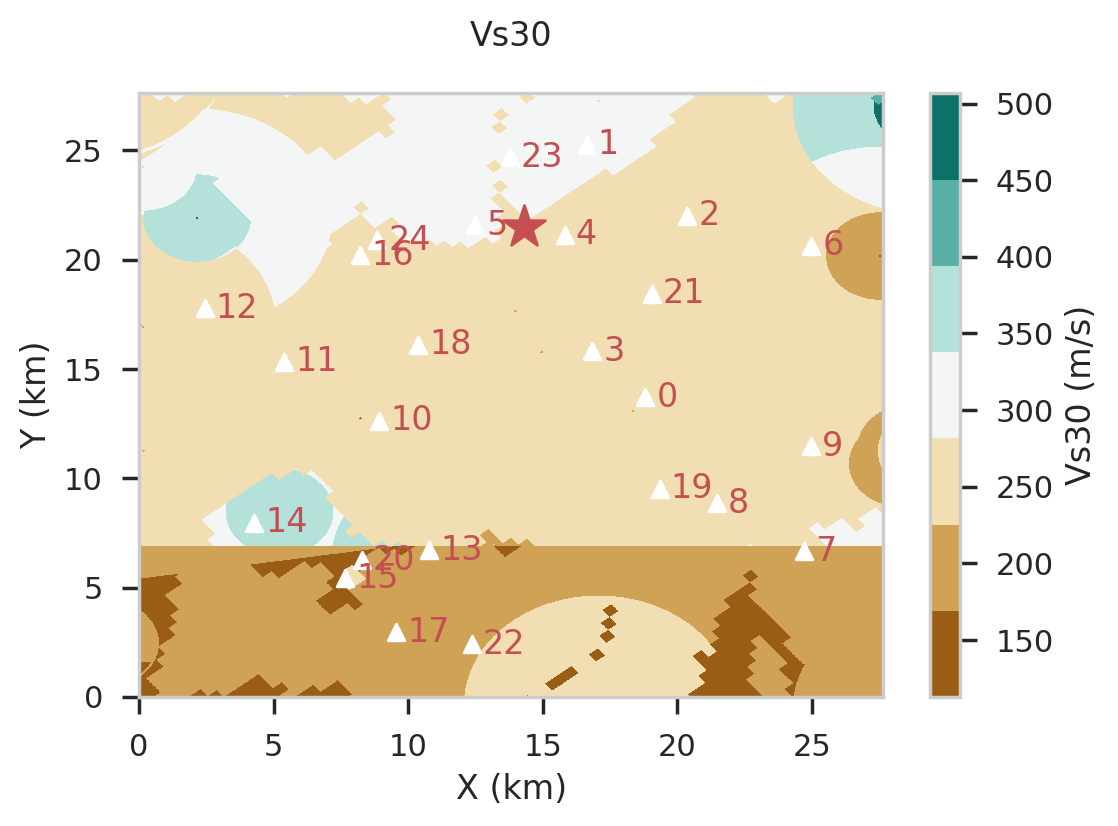

In [4]:
print(vs30[500, 500], vs30[500, -500], vs30[-500, 500], vs30[-500, -500])
for j in range(25):
    print(f"{j}, {syn_sites[j][0]}, ix = {syn_sites[j][1]}, iy = {syn_sites[j][2]}", vs30[syn_sites[j][1], syn_sites[j][2]])
    
from matplotlib.colors import ListedColormap
my_cmap = ListedColormap(sns.color_palette("BrBG", 7))

# plt.pcolormesh(np.arange(mx) * dh, np.arange(my) * dh, vs30, cmap=my_cmap, vmax=340)
# plt.colorbar()
with sns.plotting_context('notebook', font_scale=1):
    fig, ax = plt.subplots(dpi=200)
    im = ax.pcolormesh(np.arange(mx) * dh, np.arange(my) * dh, vs30, cmap=my_cmap)
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Vs30 (m/s)')
    for i, s in enumerate(syn_sites):
        ax.scatter(s[1] * dh, s[2] * dh, color='w', marker='^')
        ax.annotate(i, (s[1] * dh, s[2] * dh), xytext=(4, 0), textcoords='offset points',
                    color='r', ha='left', va='center')
    ax.scatter(srcidx[0] * dh, srcidx[1] * dh, 250, color='r', marker='*')
    ax.set_xlabel('X (km)')
    ax.set_ylabel('Y (km)')
    ax.set_title('Vs30', y=1.05)

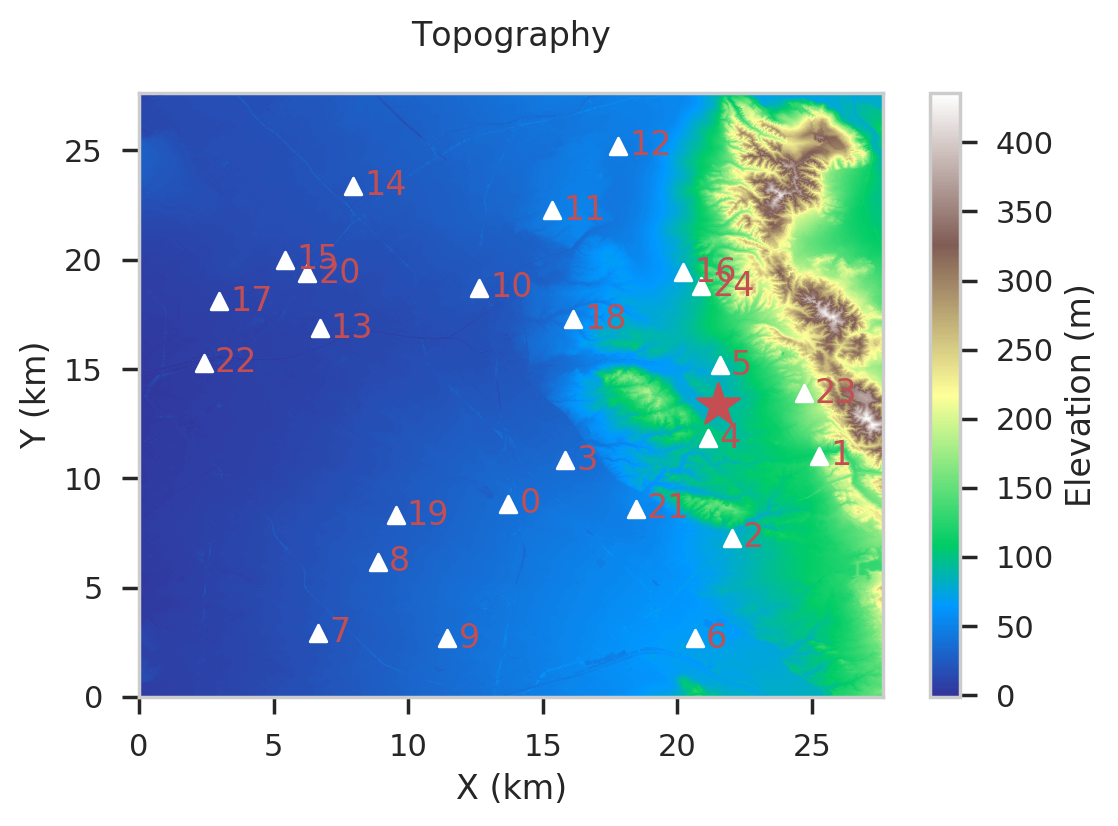

In [5]:
# For the mesh, (0, 0) is the upper left corner, X points downward (mx), Y points right (my)
# For the topography, (0, 0) is the upper left corner, X points right (my), Y points downward (mx)
# For plotting, (0, 0) is the lower left corner, X-axis points right, Y-axis points upward
%matplotlib inline
with sns.plotting_context('notebook', font_scale=1):
#plt.rcParams['figure.dpi']=100
    topography = read_topo('topography.bin')
    #topo_gradx, topo_grady = np.gradient(topography, dh * 1000)
    #topo_grad = np.sqrt(topo_gradx ** 2 + topo_grady ** 2)
    fig, ax = plt.subplots(dpi=200)
    im = ax.pcolormesh(np.arange(mx) * dh, np.arange(my) * dh, np.rot90(topography, 1), cmap='terrain')
    #plt.gca().invert_yaxis()
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Elevation (m)')
    for i, s in enumerate(syn_sites):
        ax.scatter(s[2] * dh, (mx - s[1]) * dh, color='w', marker='^')
        ax.annotate(i, (s[2] * dh, (mx - s[1]) * dh), xytext=(4, 0), textcoords='offset points',
                    color='r', ha='left', va='center')
    ax.scatter(srcidx[1] * dh, (mx - srcidx[0]) * dh, 250, color='r', marker='*')
    ax.set_xlabel('X (km)')
    ax.set_ylabel('Y (km)')
    ax.set_title('Topography', y=1.05)
    # xticks = ax.get_xticks()
    # ax.set_xticklabels(list(f'{lon[np.searchsorted(np.arange(1, nx), i)]:.2f}' for i in xticks))

In [ ]:
%matplotlib inline
vel_syn = collections.defaultdict(dict)

with open('results/vel_syn.pickle', 'rb') as fid:
    vel_syn = pickle.load(fid)

with open('results/psa_syn.pickle', 'rb') as fid:
    psa_syn = pickle.load(fid)
    
models = ["noqf_orig", "qf04_orig", "qf06_orig", "qf08_orig", "noqf_s05h005l100",
          "qf04_s05h005l100", "qf06_s05h005l100", "qf08_s05h005l100",
          "qf06_s05h005l200", "qf06_s05h005l500", "qf06_s05h010l100",
          "qf06_s05h015l100", "qf06_s10h005l100", 'flat_noqf_orig', 
          "topo_qf06_s05h005l100", 'topo_noqf_orig', 'topo_qf06_orig',
          'rwg', 'large', 'rec']

# tmp = vel_syn.pop('rwg')
# tmp = vel_syn.pop('large')
# tmp = vel_syn.pop('bw')

# for model in models:
#     try:
#         with open(Path(model, 'vel_sites.pickle'), 'rb') as fid:      
#             vel_syn[model] = pickle.load(fid) 
#             for k in vel_syn[model].keys():
#                 vel_syn[model][k] = rotate(vel_syn[model][k], -39.9)
#     except:
#         with open(f'results/vel_{model}.pickle', 'rb') as fid:
#             vel_syn[model] = pickle.load(fid)


In [ ]:
# vel_rec = collections.defaultdict(dict)
# for isite in syn_sites:
#     vel_rec[isite[0]] = read_rec(isite[0])
# vel_syn['rec'] = vel_rec
with open('results/vel_syn.pickle', 'wb') as fid:
    pickle.dump(vel_syn, fid, protocol=pickle.HIGHEST_PROTOCOL)    

# # with open('results/vel_large.pickle', 'wb') as fid:
# #     pickle.dump(vel_syn['large'], fid, protocol=pickle.HIGHEST_PROTOCOL)    

# # with open('results/vel_rwg.pickle', 'wb') as fid:
# #     pickle.dump(vel_syn['rwg'], fid, protocol=pickle.HIGHEST_PROTOCOL)    

# psa_syn = pick_psa(mx, my, models, osc_freqs=osc_freqs, syn_sites=syn_sites)
# with open('results/psa_syn.pickle', 'wb') as fid:
#     pickle.dump(psa_syn, fid, protocol=pickle.HIGHEST_PROTOCOL)  

# model = 'noqf_orig_vs500'
# with open(Path(model, 'vel_sites.pickle'), 'rb') as fid: 
#     vel_syn[model] = pickle.load(fid) 
#     for k in vel_syn[model].keys():
#         vel_syn[model][k] = rotate(vel_syn[model][k], -39.9)
        
# psa_syn[model] = pick_psa(mx, my, ['noqf_orig_vs500'], syn_sites=syn_sites)

In [ ]:
# Read large domain simulation results
if 0:
    stat_list = pd.read_csv(r'../scripts/la_habra_large_statlist.txt', delimiter=" ",
                            header=None, usecols=[0])
    stat_list =stat_list[0].tolist()
    vx = np.fromfile('/gpfs/alpine/geo112/scratch/hzfmer/high_f/la_habra_large_gpu_dm_abc50_noQf/seis_x0120000', 'f').reshape(len(stat_list), -1)
    vy = np.fromfile('/gpfs/alpine/geo112/scratch/hzfmer/high_f/la_habra_large_gpu_dm_abc50_noQf/seis_y0120000', 'f').reshape(len(stat_list), -1)
    vz = np.fromfile('/gpfs/alpine/geo112/scratch/hzfmer/high_f/la_habra_large_gpu_dm_abc50_noQf/seis_z0120000', 'f').reshape(len(stat_list), -1)

    vel_tmp = collections.defaultdict(dict)
    for i, s in enumerate(stat_list):
        vel_tmp[s.replace('_', "")]['dt'] = 0.01
        vel_tmp[s.replace('_', "")]['X'] = vx[i][:]
        vel_tmp[s.replace('_', "")]['Y'] = vy[i][:]
        vel_tmp[s.replace('_', "")]['Z'] = vz[i][:]
        vel_tmp[s.replace('_', "")] = rotate(vel_tmp[s.replace('_', "")], -39.9)
    with open('results/vel_large.pickle', 'wb') as fid:
        pickle.dump(vel_tmp, fid, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('results/vel_large.pickle', 'rb') as fid:
        vel_large = pickle.load(fid)
